In [1]:
# import numpy as np

# !pip install autograd
import autograd.numpy as np
import math
from numpy import genfromtxt
import scipy
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
#matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('font',family ='serif',size=12)
#from palettable.colorbrewer.sequential import Blues_8
#colors = Blues_8.mpl_colormap(np.linspace(0,6))
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

In [2]:
# Creating a Dictionary

vec=[0,0,0,0,0]    
lineadict={'lam1': vec, 'P11': vec, 'lam2': vec, 'P22': vec}
Dict={}

### Read data
nAN= os.listdir('Plam/')

# Info of the corresponding group of each sample:
inffo = pd.read_csv('info.csv')
infon=inffo.to_numpy()[:,:]
print(infon)

#Delete any "DS store doc"
for i in range(len(infon)):
    if nAN[i][-1]=='e':
        a=i
nAN.pop(a)


[['ctrl' '3C']
 ['ctrl' '6CS1']
 ['ctrl' 'P9C1']
 ['ctrl' 'P10C1']
 ['ctrl' 'PennyC']
 ['ctrl' 'BubblesC']
 ['xr' '5XCL']
 ['xr' '5XCR']
 ['xr' '3XC']
 ['xr' '6XCS1']
 ['xr' 'PennyXR']
 ['xr' 'BubblesXR']
 ['te' 'P10E2A1']
 ['te' 'P9E2A1']
 ['te' '3TPA1']
 ['xrte' '3XTPA1']
 ['xrte' 'PennyXRTE']
 ['xrte' '6XTPA1']
 ['xrte' '5XTPA1']]


'.DS_Store'

In [3]:
for i in range(len(nAN)):
    Dict[i]=lineadict

# print(Dict)

AN=[""]*len(nAN)
for i in range(len(infon)):
    # print(i)
    AN[i]='PK_lam_OffX_'+infon[i,1]+'.csv'
# print(AN)

for i in range(len(AN)):
    if AN[i][0]=='P':
        csvF = pd.read_csv('Plam/'+AN[i])
        AX = csvF.to_numpy()[:,1:]
        lam1=AX[:,0]
        lam2=AX[:,2]
        P11=AX[:,1]
        P22=AX[:,3]
        linee={'lam1': lam1, 'P11': P11, 'lam2': lam2, 'P22': P22}
        Dict[i]=linee


In [4]:
## Initialize vectors that store parameter values of each specimen
## Change this for storing in a directory

for j in range(len(AN)):
    Dict[j]['TlamX']=0
    Dict[j]['TstressX']=0
    Dict[j]['GlowX']=0
    Dict[j]['GhighX']=0
    Dict[j]['TlamY']=0
    Dict[j]['TstressY']=0
    Dict[j]['GlowY']=0
    Dict[j]['GhighY']=0


In [5]:
def stde(data):
    return np.std(data, ddof=1) / np.sqrt(np.size(data))

In [6]:
#Initialize vectors for storing data

lenall=len(AN)
GlowXvec=np.zeros((lenall))
GlowYvec=np.zeros((lenall))
GhighXvec=np.zeros((lenall))
GhighYvec=np.zeros((lenall))
TstressXvec=np.zeros((lenall))
TstressYvec=np.zeros((lenall))
TlamXvec=np.zeros((lenall))
TlamYvec=np.zeros((lenall))
print(len(GlowXvec))

19


In [7]:
#Initialize vectors for storing data for mean and std computation

ctrl={'TlamX':[],'TlamY':[],'TstressX':[],'TstressY':[],'GlowX':[],'GlowY':[],'GhighX':[],'GhighY':[]}
xr={'TlamX':[],'TlamY':[],'TstressX':[],'TstressY':[],'GlowX':[],'GlowY':[],'GhighX':[],'GhighY':[]}
xrte={'TlamX':[],'TlamY':[],'TstressX':[],'TstressY':[],'GlowX':[],'GlowY':[],'GhighX':[],'GhighY':[]}
te={'TlamX':[],'TlamY':[],'TstressX':[],'TstressY':[],'GlowX':[],'GlowY':[],'GhighX':[],'GhighY':[]}

In [8]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Smooth the data
window_size = 5
# y_smooth = moving_average(y, window_size)

In [9]:
# Smoothing parameters
window_length = 11  # Choose an odd number
polyorder = 2

# Differences between slopes
ci = 3
delta = 3
sldiff_vecX = []
sldiff_vecY = []  # Added for lam2 and P22
Sl_max = []
Sl_maxY = []  # Added for lam2 and P22

diff = 0.5
x = 2.5

diff2 = 0.5
x2 = 2.5

for i in range(len(AN)):
    # print(i)
    lam1 = Dict[i]['lam1']
    P11 = Dict[i]['P11']
    lam2 = Dict[i]['lam2']
    P22 = Dict[i]['P22']

    # Smoothing the curves
    # if i not in { 6, 10, 15}:
    lam1_smooth = savgol_filter(lam1, window_length, polyorder)
    P11_smooth = savgol_filter(P11, window_length, polyorder)
    lam2_smooth = savgol_filter(lam2, window_length, polyorder)
    P22_smooth = savgol_filter(P22, window_length, polyorder)

    ci_local_X = ci  # local ci variable for lam1 and P11
    ci_local_Y = ci  # local ci variable for lam2 and P22
    sldiff_vecX = []  # Clear sldiff_vec for each iteration of the outer loop
    sldiff_vecY = []  # Clear sldiff_vec for each iteration of the outer loop

    # Processing lam1 and P11
    while diff <= x:
        lam1s1 = lam1_smooth[ci_local_X - delta:ci_local_X]
        P11s1 = P11_smooth[ci_local_X - delta:ci_local_X]
        lam1s2 = lam1_smooth[ci_local_X:ci_local_X + delta]
        P11s2 = P11_smooth[ci_local_X:ci_local_X + delta]

        if len(lam1s1) != delta or len(lam1s2) != delta:
            break

        ze1 = np.zeros((1, len(lam1s1)))
        ze2 = np.zeros((1, len(lam1s2)))
        XX1 = np.vstack([lam1s1, ze1])
        XX2 = np.vstack([lam1s2, ze2])
        XXr1 = np.transpose(XX1)
        XXr2 = np.transpose(XX2)

        # Perform linear regression
        reg1 = LinearRegression().fit(XXr1, P11s1)
        reg2 = LinearRegression().fit(XXr2, P11s2)

        sl1 = reg1.coef_[0]
        sl2 = reg2.coef_[0]

        diff = abs(sl2 - sl1)
        sldiff_vecX.append(diff)
        ci_local_X = ci_local_X + 1

    if sldiff_vecX:  # Check if sldiff_vec is not empty
        max_abs_index_X = np.argmax(np.abs(sldiff_vecX))
        max_abs_value_X = sldiff_vecX[max_abs_index_X]
        Sl_max.append(max_abs_value_X)
        Dict[i]['TlamX'] = lam1[max_abs_index_X]
        Dict[i]['TstressX'] = P11[max_abs_index_X]
    
    XstretchL = lam1[0:max_abs_index_X]
    XstressL = P11[0:max_abs_index_X]
    ze = np.zeros((1, len(XstretchL)))
    XX = np.vstack([XstretchL, ze])
    XXr = np.transpose(XX)
    
    # Perform linear regression
    reg = LinearRegression().fit(XXr, XstressL)
    RR = reg.score(XXr, XstressL)

    coeff = reg.coef_
    coef = coeff[0]

    Dict[i]['GlowX'] = coef

    # print(i)
    # print('glowX')
    # print(coef)

    if infon[i, 0] == 'ctrl':
        ctrl['GlowX'].append(coef)
        ctrl['TlamX'].append(lam1[max_abs_index_X])
        ctrl['TstressX'].append(P11[max_abs_index_X])
    elif infon[i, 0] == 'xr':
        xr['GlowX'].append(coef)
        xr['TlamX'].append(lam1[max_abs_index_X])
        xr['TstressX'].append(P11[max_abs_index_X])
    elif infon[i, 0] == 'xrte':
        xrte['GlowX'].append(coef)
        xrte['TlamX'].append(lam1[max_abs_index_X])
        xrte['TstressX'].append(P11[max_abs_index_X])
    elif infon[i, 0] == 'te':
        te['GlowX'].append(coef)
        te['TlamX'].append(lam1[max_abs_index_X])
        te['TstressX'].append(P11[max_abs_index_X])

    diff = 0.5
    x = 2

    # limHX = len(lam1) - 50
    limHX = max_abs_index_X

    XstretchH = lam1[limHX:limHX+5]
    XstressH = P11[limHX:limHX+5]
    ze2 = np.zeros((1, len(XstretchH)))
    XX2 = np.vstack([XstretchH, ze2])
    XX2r = np.transpose(XX2)
    regH = LinearRegression().fit(XX2r, XstressH)
    RRh = regH.score(XX2r, XstressH)
    coefH = regH.coef_

    Dict[i]['GhighX'] = coefH[0]
    GhighXvec[i] = coefH[0]

    if infon[i, 0] == 'ctrl':
        ctrl['GhighX'].append(coefH[0])
    elif infon[i, 0] == 'xr':
        xr['GhighX'].append(coefH[0])
    elif infon[i, 0] == 'xrte':
        xrte['GhighX'].append(coefH[0])
    elif infon[i, 0] == 'te':
        te['GhighX'].append(coefH[0])

window_length2 = 5

for i in range(len(AN)):
    lam1 = Dict[i]['lam1']
    P11 = Dict[i]['P11']
    lam2 = Dict[i]['lam2']
    P22 = Dict[i]['P22']

    # Smoothing the curves
    if i not in {1, 2, 8, 9, 16}:
        lam1_smooth = savgol_filter(lam1, window_length2, polyorder)
        P11_smooth = savgol_filter(P11, window_length2, polyorder)
        lam2_smooth = savgol_filter(lam2, window_length2, polyorder)
        P22_smooth = savgol_filter(P22, window_length2, polyorder)

    ## Plot an example of a smoothed curve
    # if i==3:
    #     plt.plot(lam2,P22)
    #     plt.plot(lam2_smooth,P22_smooth)

    ci_local_X = ci  # local ci variable for lam1 and P11
    ci_local_Y = ci  # local ci variable for lam2 and P22
    sldiff_vecX = []  # Clear sldiff_vec for each iteration of the outer loop
    sldiff_vecY = []  # Clear sldiff_vec for each iteration of the outer loop

    # Processing lam2 and P22
    while diff2 <= x2:
        lam1s1 = lam2_smooth[ci_local_X - delta:ci_local_X]
        P11s1 = P22_smooth[ci_local_X - delta:ci_local_X]
        lam1s2 = lam2_smooth[ci_local_X:ci_local_X + delta]
        P11s2 = P22_smooth[ci_local_X:ci_local_X + delta]

        if len(lam1s1) != delta or len(lam1s2) != delta:
            break

        ze1 = np.zeros((1, len(lam1s1)))
        ze2 = np.zeros((1, len(lam1s2)))
        XX1 = np.vstack([lam1s1, ze1])
        XX2 = np.vstack([lam1s2, ze2])
        XXr1 = np.transpose(XX1)
        XXr2 = np.transpose(XX2)

        # Perform linear regression
        reg1 = LinearRegression().fit(XXr1, P11s1)
        reg2 = LinearRegression().fit(XXr2, P11s2)

        sl1 = reg1.coef_[0]
        sl2 = reg2.coef_[0]

        diff2 = abs(sl2 - sl1)
        sldiff_vecX.append(diff2)
        ci_local_X = ci_local_X + 1

    if sldiff_vecX:  # Check if sldiff_vec is not empty
        max_abs_index_Y = np.argmax(np.abs(sldiff_vecX))
        max_abs_value_Y = sldiff_vecX[max_abs_index_Y]
        Sl_max.append(max_abs_value_Y)
        Dict[i]['TlamY'] = lam2[max_abs_index_Y]
        Dict[i]['TstressY'] = P22[max_abs_index_Y]

    YstretchL = lam2[0:max_abs_index_Y]
    YstressL = P22[0:max_abs_index_Y]
    zee = np.zeros((1, len(YstretchL)))
    XXy = np.vstack([YstretchL, zee])
    XXyr = np.transpose(XXy)
    regy = LinearRegression().fit(XXyr, YstressL)
    RRy = regy.score(XXyr, YstressL)

    coeffy = regy.coef_
    coefy = coeffy[0]

    Dict[i]['GlowY'] = coefy

    # print(i)
    # print('glowY')
    # print(coefy)

    if infon[i, 0] == 'ctrl':
        ctrl['GlowY'].append(coefy)
        ctrl['TlamY'].append(lam2[max_abs_index_Y])
        ctrl['TstressY'].append(P22[max_abs_index_Y])
    elif infon[i, 0] == 'xr':
        if i!=6:
            xr['GlowY'].append(coefy)
        xr['TlamY'].append(lam2[max_abs_index_Y])
        xr['TstressY'].append(P22[max_abs_index_Y])
    elif infon[i, 0] == 'xrte':
        xrte['GlowY'].append(coefy)
        xrte['TlamY'].append(lam2[max_abs_index_Y])
        xrte['TstressY'].append(P22[max_abs_index_Y])
    elif infon[i, 0] == 'te':
        te['GlowY'].append(coefy)
        te['TlamY'].append(lam2[max_abs_index_Y])
        te['TstressY'].append(P22[max_abs_index_Y])
    
    GlowYvec[i] = coefy

    # Fit high modulus in Y direction
    # limHY = len(lam2) - 40
    limHY = max_abs_index_Y

    YstretchH = lam2[limHY:]
    YstressH = P22[limHY:]
    ze22 = np.zeros((1, len(YstretchH)))
    XX22 = np.vstack([YstretchH, ze22])
    XX2r2 = np.transpose(XX22)
    regHY = LinearRegression().fit(XX2r2, YstressH)
    RRYh = regHY.score(XX2r2, YstressH)
    coefHY = regHY.coef_


    Dict[i]['GhighY'] = coefHY[0]

    if infon[i, 0] == 'ctrl':
        ctrl['GhighY'].append(coefHY[0])
    elif infon[i, 0] == 'xr':
        xr['GhighY'].append(coefHY[0])
    elif infon[i, 0] == 'xrte':
        xrte['GhighY'].append(coefHY[0])
    elif infon[i, 0] == 'te':
        te['GhighY'].append(coefHY[0])

    GhighYvec[i] = coefHY[0]

    diff2 = 0.5
    x2 = 2

/Users/lnunezal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


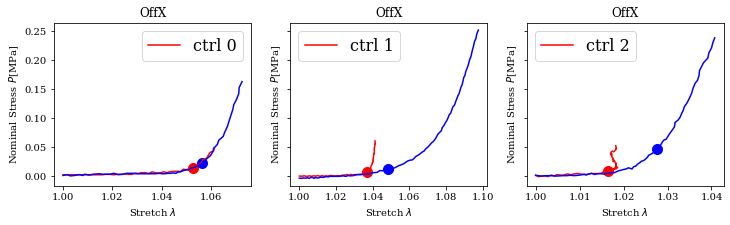

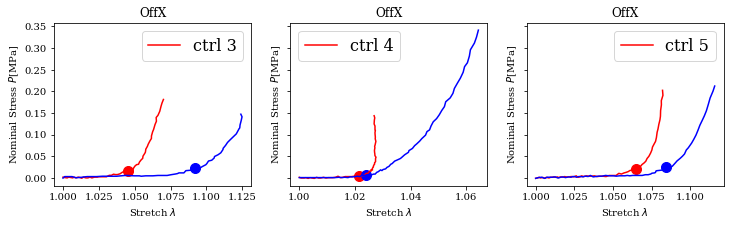

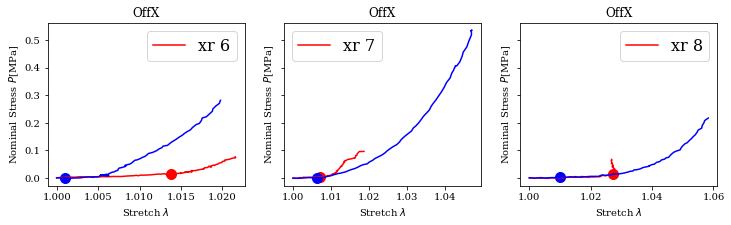

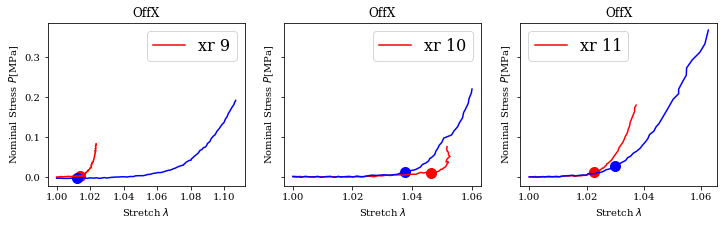

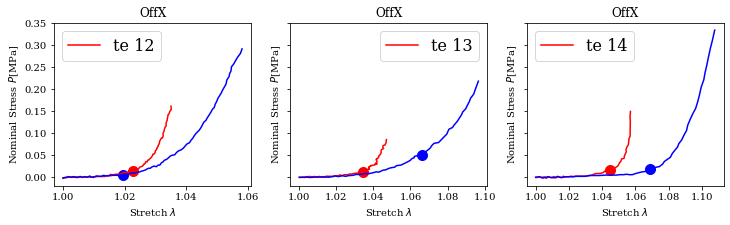

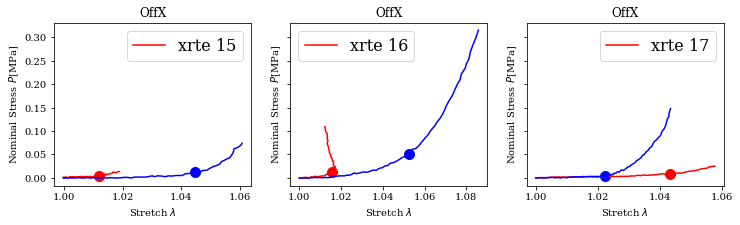

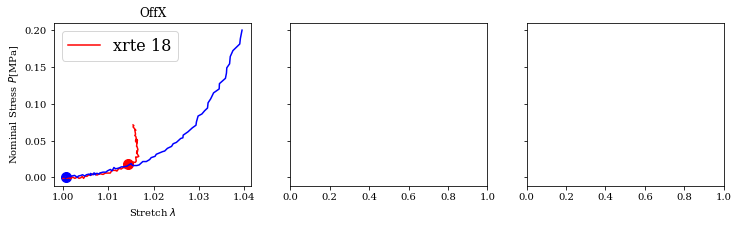

In [10]:
# Visualize all the stress stretch curves and their respectives transition points

fig,ax = plt.subplots(1,3,figsize=(12,3),sharey=True)
fig,ax2 = plt.subplots(1,3,figsize=(12,3),sharey=True)
fig,ax3 = plt.subplots(1,3,figsize=(12,3),sharey=True)
fig,ax4 = plt.subplots(1,3,figsize=(12,3),sharey=True)
fig,ax5 = plt.subplots(1,3,figsize=(12,3),sharey=True)
fig,ax6 = plt.subplots(1,3,figsize=(12,3),sharey=True)
fig,ax7 = plt.subplots(1,3,figsize=(12,3),sharey=True)


for i in range(3):
    # pos=np.array([[0,0],[]])
    ax[i].plot(Dict[i]['lam1'],Dict[i]['P11'],color='r',label=str(infon[i,0])+' '+str(i))       
    ax[i].scatter(Dict[i]['TlamX'],Dict[i]['TstressX'],color = 'r', s=100)
    ax[i].plot(Dict[i]['lam2'],Dict[i]['P22'],color='b')       
    ax[i].scatter(Dict[i]['TlamY'],Dict[i]['TstressY'],color = 'b', s=100) 
    ax[i].set_title("OffX")
    ax[i].set_xlabel(r'Stretch $\lambda$')
    ax[i].set_ylabel(r'Nominal Stress $P$[MPa]')
    ax[i].legend(fontsize=16)

for i in range(3,6):
    # pos=np.array([[0,0],[]])
    ax2[i-3].plot(Dict[i]['lam1'],Dict[i]['P11'],color='r',label=str(infon[i,0])+' '+str(i))       
    ax2[i-3].scatter(Dict[i]['TlamX'],Dict[i]['TstressX'],color = 'r', s=100)
    ax2[i-3].plot(Dict[i]['lam2'],Dict[i]['P22'],color='b')       
    ax2[i-3].scatter(Dict[i]['TlamY'],Dict[i]['TstressY'],color = 'b', s=100) 
    ax2[i-3].set_title("OffX")
    ax2[i-3].set_xlabel(r'Stretch $\lambda$')
    ax2[i-3].set_ylabel(r'Nominal Stress $P$[MPa]')
    ax2[i-3].legend(fontsize=16)

for i in range(6,9):
    # pos=np.array([[0,0],[]])
    ax3[i-6].plot(Dict[i]['lam1'],Dict[i]['P11'],color='r',label=str(infon[i,0])+' '+str(i))       
    ax3[i-6].scatter(Dict[i]['TlamX'],Dict[i]['TstressX'],color = 'r', s=100)
    ax3[i-6].plot(Dict[i]['lam2'],Dict[i]['P22'],color='b')       
    ax3[i-6].scatter(Dict[i]['TlamY'],Dict[i]['TstressY'],color = 'b', s=100) 
    ax3[i-6].set_title("OffX")
    ax3[i-6].set_xlabel(r'Stretch $\lambda$')
    ax3[i-6].set_ylabel(r'Nominal Stress $P$[MPa]')
    ax3[i-6].legend(fontsize=16)

for i in range(9,12):
    # pos=np.array([[0,0],[]])
    ax4[i-9].plot(Dict[i]['lam1'],Dict[i]['P11'],color='r',label=str(infon[i,0])+' '+str(i))       
    ax4[i-9].scatter(Dict[i]['TlamX'],Dict[i]['TstressX'],color = 'r', s=100)
    ax4[i-9].plot(Dict[i]['lam2'],Dict[i]['P22'],color='b')       
    ax4[i-9].scatter(Dict[i]['TlamY'],Dict[i]['TstressY'],color = 'b', s=100) 
    ax4[i-9].set_title("OffX")
    ax4[i-9].set_xlabel(r'Stretch $\lambda$')
    ax4[i-9].set_ylabel(r'Nominal Stress $P$[MPa]')
    ax4[i-9].legend(fontsize=16)

for i in range(12,15):
    # pos=np.array([[0,0],[]])
    ax5[i-12].plot(Dict[i]['lam1'],Dict[i]['P11'],color='r',label=str(infon[i,0])+' '+str(i))       
    ax5[i-12].scatter(Dict[i]['TlamX'],Dict[i]['TstressX'],color = 'r', s=100)
    ax5[i-12].plot(Dict[i]['lam2'],Dict[i]['P22'],color='b')       
    ax5[i-12].scatter(Dict[i]['TlamY'],Dict[i]['TstressY'],color = 'b', s=100) 
    ax5[i-12].set_title("OffX")
    ax5[i-12].set_xlabel(r'Stretch $\lambda$')
    ax5[i-12].set_ylabel(r'Nominal Stress $P$[MPa]')
    ax5[i-12].legend(fontsize=16)

for i in range(15,18):
    # pos=np.array([[0,0],[]])
    ax6[i-15].plot(Dict[i]['lam1'],Dict[i]['P11'],color='r',label=str(infon[i,0])+' '+str(i))       
    ax6[i-15].scatter(Dict[i]['TlamX'],Dict[i]['TstressX'],color = 'r', s=100)
    ax6[i-15].plot(Dict[i]['lam2'],Dict[i]['P22'],color='b')       
    ax6[i-15].scatter(Dict[i]['TlamY'],Dict[i]['TstressY'],color = 'b', s=100) 
    ax6[i-15].set_title("OffX")
    ax6[i-15].set_xlabel(r'Stretch $\lambda$')
    ax6[i-15].set_ylabel(r'Nominal Stress $P$[MPa]')
    ax6[i-15].legend(fontsize=16)

for i in {18}:
    # pos=np.array([[0,0],[]])
    ax7[i-18].plot(Dict[i]['lam1'],Dict[i]['P11'],color='r',label=str(infon[i,0])+' '+str(i))       
    ax7[i-18].scatter(Dict[i]['TlamX'],Dict[i]['TstressX'],color = 'r', s=100)
    ax7[i-18].plot(Dict[i]['lam2'],Dict[i]['P22'],color='b')       
    ax7[i-18].scatter(Dict[i]['TlamY'],Dict[i]['TstressY'],color = 'b', s=100) 
    ax7[i-18].set_title("OffX")
    ax7[i-18].set_xlabel(r'Stretch $\lambda$')
    ax7[i-18].set_ylabel(r'Nominal Stress $P$[MPa]')
    ax7[i-18].legend(fontsize=16)

In [11]:
Dictstat={}

Dictstat['Tlam']=[np.mean(TlamXvec),stde(TlamXvec),np.mean(TlamYvec),stde(TlamYvec)]
Dictstat['Tstress']=[np.mean(TstressXvec),stde(TstressXvec),np.mean(TstressYvec),stde(TstressYvec)]
Dictstat['Glow']=[np.mean(GlowXvec),stde(GlowXvec),np.mean(GlowYvec),stde(GlowYvec)]
Dictstat['Ghigh']=[np.mean(GhighXvec),stde(GhighXvec),np.mean(GhighYvec),stde(GhighYvec)]

In [12]:
## Compute mean and std values

# set width of bar
# fig,axx = plt.subplots(2,2,figsize =(12, 15))

# # set width of bar
# barWidth = 0.20
# fig,axx = plt.subplots(2,2,figsize =(12,15))

indx=3

xrte['GlowX'].pop(-indx)
xrte['GlowY'].pop(-indx)
xrte['GhighX'].pop(-indx)
xrte['GhighY'].pop(-indx)
xrte['TlamX'].pop(-indx)
xrte['TlamY'].pop(-indx)
xrte['TstressX'].pop(-indx)
xrte['TstressY'].pop(-indx)
 
# set height of bar
##Glow mean and error

CTRLglX = [np.mean(ctrl['GlowX']), np.mean(ctrl['GlowY'])]
CTRLeglX=[stde(ctrl['GlowX']), stde(ctrl['GlowY'])]
XRglX = [np.mean(xr['GlowX']), np.mean(xr['GlowY'])]
XReglX = [stde(xr['GlowX']), stde(xr['GlowY'])]
TEglX = [np.mean(te['GlowX']), np.mean(te['GlowY'])]
TEeglX = [stde(te['GlowX']), stde(te['GlowY'])]
XRTEglX = [np.mean(xrte['GlowX']), np.mean(xrte['GlowY'])]
XRTEeglX = [stde(xrte['GlowX']), stde(xrte['GlowY'])]

## Ghigh mean and error

CTRLTs2 = [np.mean(ctrl['GhighX']), np.mean(ctrl['GhighY'])]
CTRLeghX = [stde(ctrl['GhighX']), stde(ctrl['GhighY'])]
XRTs2 = [np.mean(xr['GhighX']), np.mean(xr['GhighY'])]
XReghX = [stde(xr['GhighX']), stde(xr['GhighY'])]
TEghX = [np.mean(te['GhighX']), np.mean(te['GhighY'])]
TEeghX = [stde(te['GhighX']), stde(te['GhighY'])]
XRTEghX = [np.mean(xrte['GhighX']), np.mean(xrte['GhighY'])]
XRTEeghX = [stde(xrte['GhighX']), stde(xrte['GhighY'])]

## Tlam mean and error
CTRLTlX = [np.mean(ctrl['TlamX']), np.mean(ctrl['TlamY'])]
CTRLeTlX = [stde(ctrl['TlamX']), stde(ctrl['TlamY'])]
XRTlX = [np.mean(xr['TlamX']), np.mean(xr['TlamY'])]
XReTlX = [stde(xr['TlamX']), stde(xr['TlamY'])]
TETlX = [np.mean(te['TlamX']), np.mean(te['TlamY'])]
TEeTlX = [stde(te['TlamX']), stde(te['TlamY'])]
XRTETlX = [np.mean(xrte['TlamX']), np.mean(xrte['TlamY'])]
XRTEeTlX = [stde(xrte['TlamX']), stde(xrte['TlamY'])]

## Tstress mean and error
CTRLTs = [np.mean(ctrl['TstressX']), np.mean(ctrl['TstressY'])]
CTRLeTs = [stde(ctrl['TstressX']), stde(ctrl['TstressY'])]
XRTs = [np.mean(xr['TstressX']), np.mean(xr['TstressY'])]
XReTs = [stde(xr['TstressX']), stde(xr['TstressY'])]
TETs = [np.mean(te['TstressX']), np.mean(te['TstressY'])]
TEeTs = [stde(te['TstressX']), stde(te['TstressY'])]
XRTETs = [np.mean(xrte['TstressX']), np.mean(xrte['TstressY'])]
XRTEeTs = [stde(xrte['TstressX']), stde(xrte['TstressY'])]

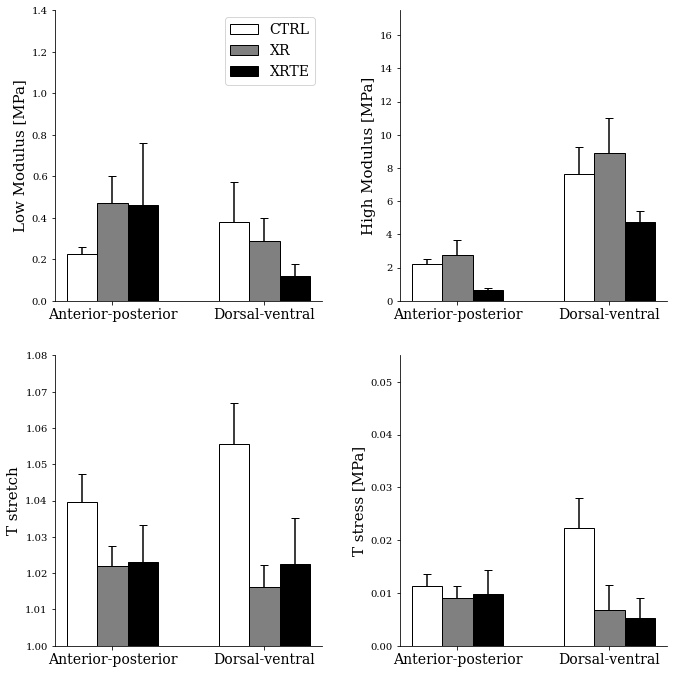

In [13]:
# set width of bar
barWidth = 0.20
fig,axx = plt.subplots(2,2,figsize =(10,10))
    
# Set position of bar on X axxis
br11 = np.arange(len(CTRLglX))
br22 = [x + barWidth for x in br11]
br44 = [x + barWidth for x in br22]
 
# Make the plot
PP11=axx[0,0].bar(br11, CTRLglX, color ='1', width = barWidth, edgecolor ='0',
                yerr = ([0,0],CTRLeglX),capsize=4,ecolor='0', label ='CTRL')
PP12=axx[0,0].bar(br22, XRglX, color ='0.5', width = barWidth, edgecolor ='0',
                yerr = ([0,0],XReglX),capsize=4,ecolor='0', label ='XR')
# PP13=axx[0,0].bar(br33, TEglX, color ='b', width = barWidth, edgecolor ='0',
#                yerr = ([0,0],TEeglX),capsize=4,ecolor='0', label ='TE')
PP14=axx[0,0].bar(br44, XRTEglX, color ='0', width = barWidth, edgecolor ='0',
                yerr = ([0,0],XRTEeglX),capsize=4,ecolor='0', label ='XRTE')

PP21=axx[0,1].bar(br11, CTRLTs2, color ='1', width = barWidth, edgecolor ='0',
                yerr = ([0,0],CTRLeghX),capsize=4,ecolor='0',label ='CTRL')
pp22=axx[0,1].bar(br22, XRTs2, color ='0.5', width = barWidth, edgecolor ='0', 
                yerr = ([0,0],XReghX),capsize=4,ecolor='0',label ='XRT')
# pp23=axx[0,1].bar(br33, TEghX, color ='b', width = barWidth, edgecolor ='0',
#                yerr = ([0,0],TEeghX),capsize=4,ecolor='0',label ='TE')
pp24=axx[0,1].bar(br44, np.abs(XRTEghX), color ='0', width = barWidth, edgecolor ='0',
                yerr = ([0,0],XRTEeghX),capsize=4,ecolor='0',label ='XRT+TE')

PP31=axx[1,0].bar(br11, CTRLTlX, color ='1', width = barWidth,edgecolor ='0',
                yerr = ([0,0],CTRLeTlX),capsize=4,ecolor='0',label ='CTRL')
pp32=axx[1,0].bar(br22, XRTlX, color ='0.5', width = barWidth,edgecolor ='0',
                yerr = ([0,0],XReTlX),capsize=4,ecolor='0',label ='XRT')
# pp33=axx[1,0].bar(br33, TETlX, color ='b', width = barWidth, edgecolor ='0',
#                yerr = ([0,0],TEeTlX),capsize=4,ecolor='0',label ='TE')
pp34=axx[1,0].bar(br44, XRTETlX, color ='0', width = barWidth, edgecolor ='0',
                yerr = ([0,0],XRTEeTlX),capsize=4,ecolor='0',label ='XRT+TE')

PP41=axx[1,1].bar(br11, CTRLTs, color ='1', width = barWidth, edgecolor ='0',
                yerr = ([0,0],CTRLeTs),capsize=4,ecolor='0',label ='CTRL')
pp42=axx[1,1].bar(br22, XRTs, color ='0.5', width = barWidth, edgecolor ='0',
                yerr = ([0,0],XReTs),capsize=4,ecolor='0',label ='XRT')
# pp43=axx[1,1].bar(br33, TETs, color ='b', width = barWidth, edgecolor ='0',
#                yerr = ([0,0],TEeTs),capsize=4,ecolor='0',label ='TE')
pp44=axx[1,1].bar(br44, XRTETs, color ='0', width = barWidth, edgecolor ='0',
                yerr = ([0,0],XRTEeTs),capsize=4,ecolor='0',label ='XRT+TE')

# Eliminate borders
for i in [0,1]:
    for j in [0,1]:
        axx[i,j].spines['right'].set_visible(False)
        axx[i,j].spines['top'].set_visible(False)
        # axx[0,j].get_xaxis().set_visible(False)
        axx[i,j].set_xticks([0.20, 1.20],['Anterior-posterior', 'Dorsal-ventral'], fontsize=14)


# Adding Xticks
axx[0,0].set_ylabel('Low Modulus [MPa]', fontsize = 15)
axx[0,1].set_ylabel('High Modulus [MPa]', fontsize = 15)
axx[1,0].set_ylabel('T stretch', fontsize = 15)
axx[1,1].set_ylabel('T stress [MPa]', fontsize = 15)
axx[0,0].set_ylim(0,1.4)
axx[0,1].set_ylim(0,17.5)
axx[1,0].set_ylim(1.000,1.08)
axx[1,1].set_ylim(0,0.055)

axx[0,0].legend(fontsize=14)
fig.tight_layout(pad=3.0)


In [14]:
# Concatenate vectors
concatenated_array = np.column_stack((infon, GlowXvec, GlowYvec, GhighXvec, GhighYvec, TstressXvec, TstressYvec, TlamXvec, TlamYvec))

# Define column names
column_names = ['group', 'sample','GlowXvec', 'GlowYvec', 'GhighXvec', 'GhighYvec', 'TstressXvec', 'TstressYvec', 'TlamXvec', 'TlamYvec']

# Create a DataFrame
df = pd.DataFrame(concatenated_array, columns=column_names)

# Save the DataFrame to a CSV file
# df.to_csv('concatenated_array_Bubbles.csv', index=False)